<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/Brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups

In [ ]:
!pip install torchinfo

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imgaug
from glob import glob
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from torchinfo import summary

# Raw data

In [3]:
# download dataset
!gdown --id 1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H --output data.zip

# unzip file
!unzip -q data.zip

# remove zip file
os.remove("data.zip")

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ukyrNphtS_FT2szqHOlc491Rx6kMuR6H
To: /content/data.zip
100% 130M/130M [00:04<00:00, 31.5MB/s]


In [4]:
# Path
mask_paths = glob("brain-mri-seg/train/*_mask.tif")

mask_path = np.random.choice(mask_paths)
img_path = mask_path.replace("_mask", "")

# Open Path
mask = cv2.imread(mask_path)        # cv2 will return numpy
img = cv2.imread(img_path)          # PIL will return PIL object

print(f"mask_path: {mask_path}\nimg_path: {img_path}\n")
print(f"Maks's shape: {mask.shape} | Image's shape: {img.shape}")

mask_path: brain-mri-seg/train/TCGA_HT_7879_19981009_9_mask.tif
img_path: brain-mri-seg/train/TCGA_HT_7879_19981009_9.tif

Maks's shape: (256, 256, 3) | Image's shape: (256, 256, 3)


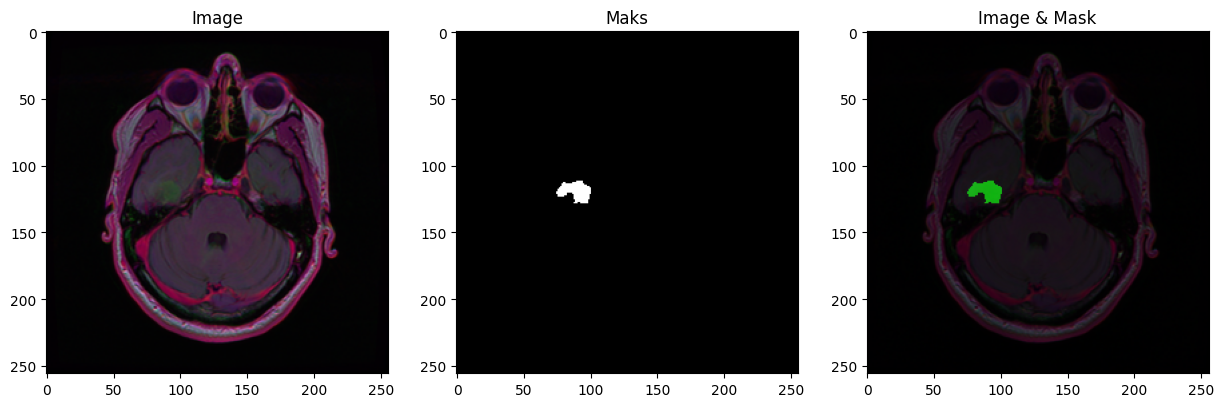

In [5]:
# Show image, mask
def plot_img_mask(img, mask):
    plt.figure(figsize = (15, 6))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title("Maks")
    plt.imshow(mask)

    plt.subplot(1, 3, 3)
    plt.title("Image & Mask")
    plt.imshow(img)
    plt.imshow(mask * np.array([0, 1, 0]), alpha = 0.6)     # *np.array([0, 0, 0]) 可以將mask轉換成指定顏色

    plt.show()

plot_img_mask(img, mask)

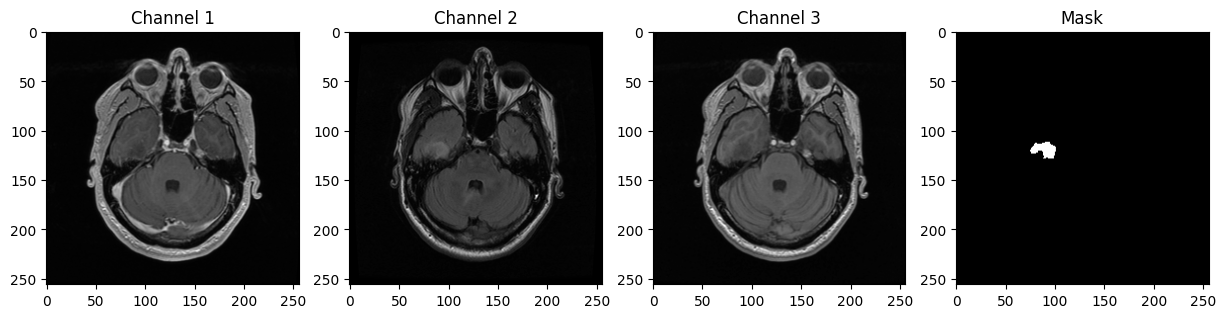

In [6]:
# 每一個 tif 檔案中, 有3張影像
plt.figure(figsize = (15, 6))

for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.title(f"Channel {i+1}")
    plt.imshow(img[:, :, i], cmap = "gray")

plt.subplot(1, 4, 4)
plt.title("Mask")
plt.imshow(mask)

plt.show()

# Function

In [38]:
class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, img_size, augmentation = False):
        # Read mask paths
        self.mask_paths = glob(os.path.join(folder_path, "*_mask.tif"))
        # Image path
        self.img_paths = [m_path.replace("_mask", "") for m_path in self.mask_paths]
        self.img_size = img_size

        # Data augmentation
        self.augmentation = augmentation
        self.augmentor = imgaug.augmenters.Sequential([
            imgaug.augmenters.Fliplr(0.5),
            imgaug.augmenters.Affine(rotate = (-45, 45),
                                     shear = (-16, 16),
                                     scale = (0.8, 1.2))])

    # 取得數據集長度, 以配合 BATCH_SiZE (img_paths, mask_paths 都可以)
    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        # IMAGE: path -> img -> resize -> Normalize
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255

        # MASK: path -> img -> resize -> channels 3 to 1 -> 黑白化
        mask_path = self.mask_paths[idx]
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = mask[:, :, :1]
        mask = np.where(mask<127, 0, 1).astype(np.int16)

        if self.augmentation:
            mask = imgaug.augmentables.segmaps.SegmentationMapsOnImage(mask, shape = mask.shape)

            # Transform
            img, mask = self.augmentor(image = img, segmentation_maps = mask)
            mask = mask.get_arr()

        img = torch.tensor(img, dtype = torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype = torch.float).permute(2, 0, 1)

        return img, mask

In [39]:
IMG_SIZE = 256

train_dataset = TumorDataset("/content/brain-mri-seg/train",
                             img_size = IMG_SIZE,
                             augmentation = True)

val_dataset = TumorDataset("/content/brain-mri-seg/test",
                           img_size = IMG_SIZE)

In [40]:
BATCH_SIZE = 12

train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               drop_last = True)

val_dataloader = torch.utils.data.DataLoader(dataset = val_dataset,
                                             batch_size = BATCH_SIZE)

In [45]:
img, mask = train_dataset[0]
print(f"img: {img.shape} | mask: {mask.shape}")

img: torch.Size([3, 256, 256]) | mask: torch.Size([1, 256, 256])


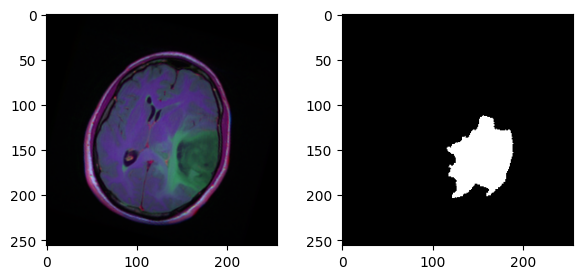

In [46]:
img = img.numpy().transpose(1, 2, 0) # (C, H, W) -> (H, W, C)
mask = mask.numpy().squeeze() # (1, H, W) -> (H, W)
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

# Model


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Squential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def __call__(self, x):
        return self.conv(x)

# temp
